In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('labeled_french_sentences.csv');
print(df.columns)

Index(['Texte ', 'Average Annotation'], dtype='object')


In [ ]:
df.columns = ['text', 'level']
print(df.columns)
df['text'] = df['text'].str.strip()
df['level'] = df['level'].str.strip()
sentences = df['text'].values
print(sentences[0])

Index(['text', 'level'], dtype='object')
Je venais de finir à vingt-deux ans mes études à l’université de Gœttingue.


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.tokenize import word_tokenize
import string

tokenized_senctences = []
for s in sentences:
  tokenized_senctences.append(word_tokenize(s, language='french'))

In [ ]:
!pip install wordstats

     |████████████████████████████████| 3.6MB 2.9MB/s 
  Created wheel for wordstats: filename=wordstats-1.0.7-cp37-none-any.whl size=3616377 sha256=34c67fc16fce96f1d0a14fc68ebf903ecf72bce0dccbb1ee95ab8b52e667d8d4
  Stored in directory: /root/.cache/pip/wheels/19/cd/63/4f1be9b37f67fd5f305b3c7ac88fc8afdb88638589cfa37184
  Created wheel for configobj: filename=configobj-5.0.6-cp37-none-any.whl size=34547 sha256=4dc4f57b655dd892bc0672d9bc7742edaa2dea78173f7420bce71edb2675ecb4
  Stored in directory: /root/.cache/pip/wheels/f1/e4/16/4981ca97c2d65106b49861e0b35e2660695be7219a2d351ee0
Successfully built wordstats configobj


In [ ]:
from wordstats import Word
# frequency is the calcualted by taking the log from it. 
# frequency of 'de' = round(math.log(7225478), 2) = 15.79
def difficulty(sentence):
  freq_sum = 0
  
  for word in sentence:
   freq_sum = freq_sum + Word.stats(word, 'fr').frequency
  
  freq_mean = freq_sum/len(sentence)
  return freq_mean

In [ ]:
print(difficulty('de'))

9.31


In [ ]:
X = []

# calculate avarage word difficulty and length
for s in tokenized_senctences:
  sum = 0
  count = 0
  for t in s:
    d = difficulty(t)
    if (d > 0):
      sum += d
      count += 1
  X.append([sum/count, len(s)])

X = np.array(X)




In [ ]:

y = df['level'].values

Text(0, 0.5, 'word count')

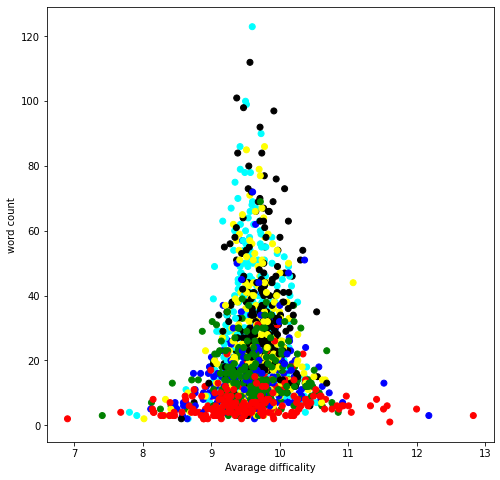

In [ ]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(figsize = (8, 8))
colors = {'A1':'red', 'A2':'green', 'B1':'blue', 'B2':'yellow', 'C1':'black', 'C2': 'cyan'}
ax.scatter(X[:, 0],X[:, 1], c=[colors[k] for k in y])

plt.xlabel("Avarage difficality")
plt.ylabel("word count")


## Logistic regression

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Use score method to get accuracy of model
score = logisticRegr.score(x_test, y_test)
print(score)

0.38620689655172413


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [ ]:
y_pred = logisticRegr.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[41  8  0  0  0  1]
 [11 27  0  0  0  9]
 [11 29  0  0  3  6]
 [ 9 12  0  0  3 16]
 [ 3  9  0  0 10 26]
 [ 8  6  0  0  8 34]]


In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          A1       0.49      0.82      0.62        50
          A2       0.30      0.57      0.39        47
          B1       0.00      0.00      0.00        49
          B2       0.00      0.00      0.00        40
          C1       0.42      0.21      0.28        48
          C2       0.37      0.61      0.46        56

    accuracy                           0.39       290
   macro avg       0.26      0.37      0.29       290
weighted avg       0.27      0.39      0.30       290



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**results are bad**

## Naive Bayes

In [ ]:
import pdb
from nltk.corpus import stopwords, twitter_samples
import numpy as np
import pandas as pd
import nltk
import string
from nltk.tokenize import TweetTokenizer
from os import getcwd

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.tokenize import word_tokenize
import string
from nltk.stem.snowball import SnowballStemmer

stimmer = SnowballStemmer('french', ignore_stopwords=True)

def process_senctence(senctence):
    '''
    Input:
        senctence: a string containing a french sentence
    Output:
        senctence_out: a list of words containing the processed sentence

    '''
    sentence_tokens = word_tokenize(senctence, language='french')

    senctence_out = []
    for word in sentence_tokens:
        if (word not in string.punctuation):  # remove punctuation
            # senctence_out.append(stimmer.stem(word))
            senctence_out.append(word)

    return senctence_out

In [ ]:
print(process_senctence(df['text'][0]))

['je', 'ven', 'de', 'fin', 'à', 'vingt-deux', 'an', 'mes', 'étud', 'à', 'l', '’', 'univers', 'de', 'gœttingu']


In [ ]:
def count_words(result, sentences, ys):
    '''
    Input:
        result: a dictionary that will be used to map each pair to its frequency
        sentences: a list of senctences
        ys: a list corresponding to the level of each senctence (A1, A2, B1, B2,
          C1, C2)
    Output:
        result: a dictionary mapping each pair to its frequency
    '''

    for y, senctence in zip(ys, sentences):
      if type(senctence) == str:
        for word in process_senctence(senctence):
            pair = (word, y)
            if pair in result:
                result[pair] += 1
            else:
                result[pair] = 1

    return result

In [ ]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of sentences
        train_y: a list of labels correponding to the sentences (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0

    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    # calculate N_pos and N_neg
    N_pos = N_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] == 1:

            # Increment the number of positive words by the count for this (word, label) pair
            N_pos += freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            N_neg += freqs[pair]

    # Calculate D, the number of documents
    D = len(train_y)

    # Calculate D_pos, the number of positive documents (*hint: use sum(<np_array>))
    D_pos = np.sum((train_y).astype(int))

    # Calculate D_neg, the number of negative documents (*hint: compute using D and D_pos)
    D_neg = D - D_pos

    # Calculate logprior
    logprior = np.log(D_pos) - np.log(D_neg)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = freqs[(word, 1)] if (word, 1) in freqs else 0
        freq_neg = freqs[(word, 0)] if (word, 0) in freqs else 0

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos) - np.log(p_w_neg)

    ### END CODE HERE ###

    return logprior, loglikelihood


In [ ]:
def naive_bayes_predict(sentence, logprior, loglikelihood):
    '''
    Input:
        sentence: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Output:
        p: the sum of all the logliklihoods of each word in the sentence (if found in the dictionary) + logprior (a number)

    '''
    # process the sentence to get a list of words
    word_l = process_senctence(sentence)

    # initialize probability to zero
    p = 0

    # add the logprior
    p += logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            p += loglikelihood[word]

    return p

In [ ]:
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: List of sentences
        test_y: Labels corresponding to the list of sentences
        logprior: Log prior
        loglikelihood: Dictionary mapping words to their loglikelihoods
    Output:
        accuracy: (# of sentences classified correctly) / (total # of sentences)
    """

    # START CODE HERE

    # List of predicted labels:
    y_hats = []

    for sentence in test_x:
        # Prediction is > 0:
        if naive_bayes_predict(sentence, logprior, loglikelihood) > 0:
            # Predicted label is 1:
            y_hat_i = 1
        else:
            # Predicted label is 0:
            y_hat_i = 0
        # Append the predicted label to the list y_hats:
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between
    # test_y and y_hats:
    error = test_y - np.array(y_hats)
    error = np.mean(np.absolute(error))

    # accuracy is 1 minus the error:
    accuracy = 1 - error

    # END CODE HERE

    return accuracy

In [ ]:
result = {}
temp_sentences = df['text'][1:3]
ys = df['level'][1:3]
print(count_words(result, temp_sentences, ys))

{('L', 'B2'): 1, ('’', 'B2'): 4, ('intention', 'B2'): 1, ('de', 'B2'): 5, ('mon', 'B2'): 1, ('père', 'B2'): 1, ('ministre', 'B2'): 1, ('l', 'B2'): 2, ('électeur', 'B2'): 1, ('***', 'B2'): 1, ('était', 'B2'): 2, ('que', 'B2'): 1, ('je', 'B2'): 1, ('parcourusse', 'B2'): 1, ('les', 'B2'): 2, ('pays', 'B2'): 1, ('plus', 'B2'): 1, ('remarquables', 'B2'): 1, ('Europe', 'B2'): 1, ('Il', 'B2'): 1, ('voulait', 'B2'): 1, ('ensuite', 'B2'): 1, ('m', 'B2'): 1, ('appeler', 'B2'): 1, ('auprès', 'B2'): 1, ('lui', 'B2'): 2, ('me', 'B2'): 2, ('faire', 'B2'): 1, ('entrer', 'B2'): 1, ('dans', 'B2'): 1, ('le', 'B2'): 2, ('département', 'B2'): 1, ('dont', 'B2'): 1, ('la', 'B2'): 1, ('direction', 'B2'): 1, ('confiée', 'B2'): 1, ('et', 'B2'): 1, ('préparer', 'B2'): 1, ('à', 'B2'): 1, ('remplacer', 'B2'): 1, ('un', 'B2'): 1, ('jour', 'B2'): 1}


In [ ]:
all_sentences = df['text'].str.strip().to_numpy()
all_levels = df['level'].str.strip().to_numpy()

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(all_sentences, all_levels, test_size=0.2, random_state=0)

In [ ]:
def train(level, x_train, y_train, x_test, y_test):
  a1_y_train = (y_train == level).astype(int)
  a1_y_test = (y_test == level).astype(int)

  freqs = count_words({}, x_train, a1_y_train)

  logprior, loglikelihood = train_naive_bayes(freqs, x_train, a1_y_train)
  accuracy = test_naive_bayes(x_test, a1_y_test, logprior, loglikelihood)
  return logprior, loglikelihood, accuracy

In [ ]:
level = 'B2'
logprior, loglikelihood, accuracy = train('A1', x_train, y_train, x_test, y_test)
print("A1 - Naive Bayes accuracy = %0.4f" % accuracy)

logprior, loglikelihood, accuracy = train('A2', x_train, y_train, x_test, y_test)
print("A2 - Naive Bayes accuracy = %0.4f" % accuracy)

logprior, loglikelihood, accuracy = train('B1', x_train, y_train, x_test, y_test)
print("B1 - Naive Bayes accuracy = %0.4f" % accuracy)

logprior, loglikelihood, accuracy = train('B1', x_train, y_train, x_test, y_test)
print("B2 - Naive Bayes accuracy = %0.4f" % accuracy)

logprior, loglikelihood, accuracy = train('C1', x_train, y_train, x_test, y_test)
print("C1 - Naive Bayes accuracy = %0.4f" % accuracy)

logprior, loglikelihood, accuracy = train('C2', x_train, y_train, x_test, y_test)
print("C2 - Naive Bayes accuracy = %0.4f" % accuracy)

A1 - Naive Bayes accuracy = 0.8621
A2 - Naive Bayes accuracy = 0.8241
B1 - Naive Bayes accuracy = 0.8414
B2 - Naive Bayes accuracy = 0.8414
C1 - Naive Bayes accuracy = 0.8483
C2 - Naive Bayes accuracy = 0.8345


# Classification with more features
